# Abstract Sentence Classification 

A deep learning NLP model that can skim any medical RCT abstract and return a well structured abstract.

ie:, The model seperated each sentence of the abstract and divides them into classes such as OBJECTIVE, METHODS, BACKGROUND, CONCLUSION, and RESULTS based on their actual purpose.

## Get the data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Set data directory
data_dir = "/content/drive/MyDrive/Colab Notebooks/Dataset/Abstract_Dataset/"

In [6]:
# Check the files in the working directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/drive/MyDrive/Colab Notebooks/Dataset/Abstract_Dataset/dev.txt',
 '/content/drive/MyDrive/Colab Notebooks/Dataset/Abstract_Dataset/test.txt',
 '/content/drive/MyDrive/Colab Notebooks/Dataset/Abstract_Dataset/train.txt']

This is how a single abstract from the dataset looks like :

'###24290286

**BACKGROUND**	IgE sensitization .....

**BACKGROUND**	It is not clear whether these patients would benefit from antifungal treatment .

**OBJECTIVE**	We sought to determine whether a @-month course of voriconazole improved asthma-related ....

**METHODS**	Asthmatic patients who were IgE sensitized to A fumigatus with a history of at least @ severe exacerbations in the previous @ months were treated for @ months .....

**METHODS**	Primary outcomes were improvement in quality of life at the end of the treatment period and a reduction in the number of severe exacerbations over the @ months .....

**RESULTS**	Sixty-five patients were randomized .

**RESULTS**	Fifty-nine patients started treatment ....

**RESULTS**	Fifty-six patients took the full @ months of medication .

RESULTS	Between the voriconazole and placebo groups , there were no significant differences in the number of ....

CONCLUSIONS	We were unable to ....


---








## Preprocess data




### Create list of dictionaries

In [7]:
# To read lines of document
def get_lines(filename):
  """
  Read the filename and returns the lines of text as a list
  """
  with open(filename, 'r') as f:
    return f.readlines()

In [8]:
train_lines = get_lines(data_dir+"train.txt") # read the lines with the training file
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [9]:
# To get the filename and create a list of dictionaries containing all data

def preprocess_text(filename):
  """
  Returns a list of dictionaries that contains text, line_number and total_line_number of each abstract
  """
  input_lines = get_lines(filename)
  abstract_lines = "" # create an empty abstract line holder
  abstract_samples = [] # this list will later contain all the dictionaries

  # loop through each line in input_lines
  for line in input_lines:
    if line.startswith("###"): # checking to see if the line is a new abstract
      abstract_id = line
      abstract_lines = ""

    elif line.isspace(): # check is line is new line ie, '\n\
      abstract_line_split = abstract_lines.splitlines()

      # iterate through each line in abstract_line_split and count them
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t")
        line_data['target'] = target_text_split[0]
        line_data['text'] = target_text_split[1].lower()
        line_data['line_number'] = abstract_line_number
        line_data['total_lines'] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)

    else: # if above conditions arent fulfilled the lines contain a valid text of an abstract
      abstract_lines += line

  return abstract_samples

In [10]:
# Get the data from file and preprocess it
train_samples = preprocess_text(data_dir + "train.txt")
val_samples = preprocess_text(data_dir + "dev.txt")
test_samples = preprocess_text(data_dir + "test.txt")
print(len(train_samples)), print(len(val_samples)), print(len(test_samples))

180040
30212
30135


(None, None, None)

In [11]:
# See few samples from train_samples
train_samples[:7]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

### Create a dataframe

In [12]:
import pandas as pd

In [13]:
# turn list of dictionaries into dataframe
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df[:14]

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [14]:
# See distribution of labels
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Frequency')

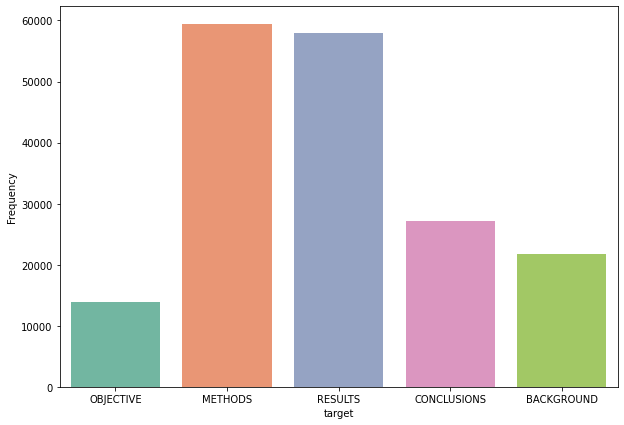

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
ax = sns.countplot('target',data=train_df, palette = "Set2");

#for p in ax.patches:
 # ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', va='top', color='black', size=10)

plt.ylabel('Frequency')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Frequency')

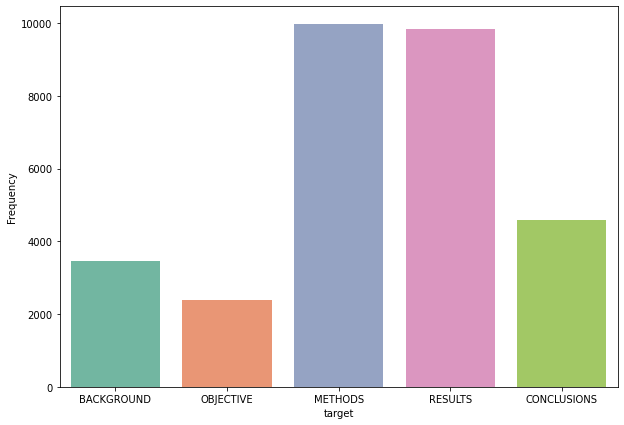

In [16]:
plt.figure(figsize=(10,7))
ax = sns.countplot('target',data=val_df, palette = "Set2");

#for p in ax.patches:
  #ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', va='top', color='black', size=10)
plt.ylabel('Frequency')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Frequency')

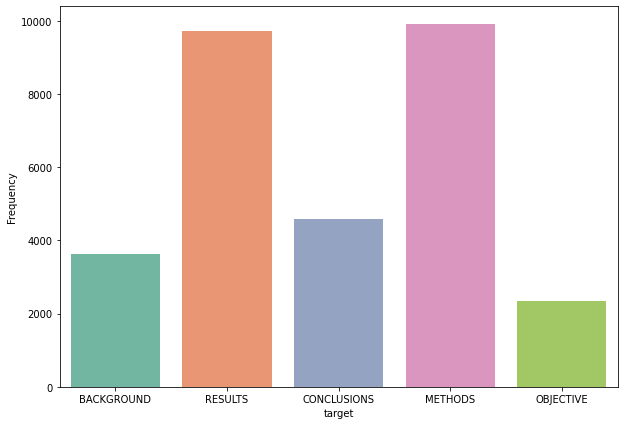

In [17]:
plt.figure(figsize=(10,7))
ax = sns.countplot('target',data=test_df, palette = "Set2");

#for p in ax.patches:
  #ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', va='top', color='black', size=10)
plt.ylabel('Frequency')

In [18]:
import string,time
string.punctuation
exclude = string.punctuation

In [19]:
def remove_punc(text):
  return text.translate(str.maketrans('', '', string.punctuation))

In [20]:
train_df['text']=train_df['text'].apply(remove_punc)

In [21]:
train_df.head(10)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of weeks of daily...,0,11
1,METHODS,a total of patients with primary knee oa were...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,serum levels of interleukin il il tumor n...,5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ...,7,11
8,RESULTS,further there was a clinically relevant reduc...,8,11
9,RESULTS,these differences remained significant at weeks,9,11


In [22]:
val_df['text']=val_df['text'].apply(remove_punc)

In [23]:
test_df['text']=test_df['text'].apply(remove_punc)

In [24]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

In [25]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [26]:
from nltk.corpus import stopwords

In [27]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [28]:
def remove_stopwords(text):
  L=[]
  for i in text.split():
    if i in stopwords.words('english'):
      L.append('')
    else:
      L.append(i)
  x = L[:]
  L.clear()
  return " ".join(x)

In [29]:
train_df['text']=train_df['text'].apply(remove_stopwords)

In [30]:
val_df['text']=val_df['text'].apply(remove_stopwords)

In [31]:
test_df['text']=test_df['text'].apply(remove_stopwords)

In [32]:
train_df.head(10)

,target,text,line_number,total_lines
0,OBJECTIVE,investigate efficacy weeks daily lowdose o...,0,11
1,METHODS,total patients primary knee oa randomized ...,1,11
2,METHODS,outcome measures included pain reduction impr...,2,11
3,METHODS,pain assessed using visual analog pain scale mm,3,11
4,METHODS,secondary outcome measures included western o...,4,11
5,METHODS,serum levels interleukin il il tumor necrosis...,5,11
6,RESULTS,clinically relevant reduction interventio...,6,11
7,RESULTS,mean difference treatment arms ci p p p p ...,7,11
8,RESULTS,clinically relevant reduction serum leve...,8,11
9,RESULTS,differences remained significant weeks,9,11


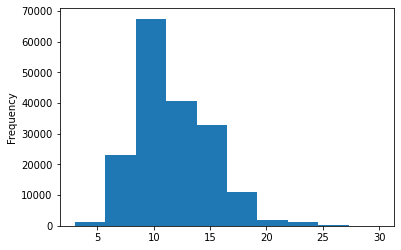

In [33]:
# check length of different lines
train_df.total_lines.plot.hist();

### Get the list of sentences

In [34]:
# convert abstract text lines to lists
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [35]:
# view lines from train_sentences
train_sentences[:10]

[' investigate  efficacy  weeks  daily lowdose oral prednisolone  improving pain mobility  systemic lowgrade inflammation   short term  whether  effect would  sustained  weeks  older adults  moderate  severe knee osteoarthritis oa',
 ' total  patients  primary knee oa  randomized received mgday  prednisolone  received placebo  weeks',
 'outcome measures included pain reduction  improvement  function scores  systemic inflammation markers',
 'pain  assessed using  visual analog pain scale mm',
 'secondary outcome measures included  western ontario  mcmaster universities osteoarthritis index scores patient global assessment pga   severity  knee oa  min walk distance mwd',
 'serum levels  interleukin il il tumor necrosis factor tnf  highsensitivity creactive protein hscrp  measured',
 '   clinically relevant reduction   intervention group compared   placebo group  knee pain physical function pga  mwd  weeks',
 ' mean difference  treatment arms ci  p p p  p respectively',
 '    clinically r

### Make numerical labels

In [36]:
# One hot encode the labels
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse = False) # False because we dont want sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1,1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [37]:
# Label encode the labels
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [38]:
# get the class names and number of classes from label_encoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

### Preparing data for deep learning model

In [39]:
# Import needed libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers 

In [40]:
# How long is each sentence on average
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_lens = np.round(np.mean(sent_lens))
avg_sent_lens

13.0

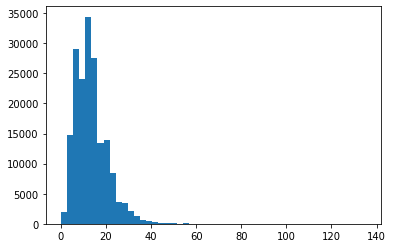

In [41]:
# What the distribution looks like
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins = 50);

In [42]:
# How long of a sentence length covers 95% of data
output_seq_length = int(np.percentile(sent_lens, 95))
maximum_sent_length = max(sent_lens)
output_seq_length, maximum_sent_length

(26, 135)

### Create a text Vectorizer



In [43]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [44]:
max_tokens = 68000 # mentioned in the research paper

# Create the text_vectorization layer
text_vectorizer = TextVectorization(max_tokens = max_tokens,
                                    split='whitespace',
                                    ngrams = None,
                                    output_mode ='int',
                                    output_sequence_length = 26,
                                    pad_to_max_tokens = True)

In [45]:
# Adapt text vectorizer to train_data
text_vectorizer.adapt(train_sentences)

In [46]:
# test the text vectorizer
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
treatment  pregnenolone elevates allopregnanolone  neurosteroid  enhances gabaa receptor responses  pregnenolone sulfate  positive nmda receptor modulator

Length of text: 15

Vectorized text: [[    6 12928 17127 64031 25443  3882 26333   663   367 12928  2579   219
  13721   663 10134     0     0     0     0     0     0     0     0     0
      0     0]]


In [47]:
# Vocabulary details
vocab = text_vectorizer.get_vocabulary()
print(f"Number of words i vocab: {len(vocab)}")
print(f"Most common words in vocab: {vocab[:5]}")
print(f"Most rare words in vocab: {vocab[-5:]}")

Number of words i vocab: 64711
Most common words in vocab: ['', '[UNK]', 'patients', 'group', 'p']
Most rare words in vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


### Create custom embedding layer

In [48]:
token_embed = layers.Embedding(input_dim= len(vocab),
                               output_dim = 128,
                               name = 'token_embedding_CUSTOM')

In [49]:
# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization:\n{vectorized_sentence}\n")
print(f"vectroized sentence shape: {vectorized_sentence.shape}\n")

embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
treatment  pregnenolone elevates allopregnanolone  neurosteroid  enhances gabaa receptor responses  pregnenolone sulfate  positive nmda receptor modulator

Sentence after vectorization:
[[    6 12928 17127 64031 25443  3882 26333   663   367 12928  2579   219
  13721   663 10134     0     0     0     0     0     0     0     0     0
      0     0]]

vectroized sentence shape: (1, 26)

Sentence after embedding:
 [[[-0.00181203 -0.04956932  0.00663842 ...  0.00284148  0.04214182
   -0.00757893]
  [ 0.01620659 -0.03711711 -0.04649273 ... -0.01996662  0.03767307
    0.04325665]
  [ 0.01992242  0.01786324 -0.02161523 ... -0.019834    0.02110645
    0.0228473 ]
  ...
  [-0.00267271  0.02817083  0.02864555 ... -0.04683124 -0.03340641
    0.03854848]
  [-0.00267271  0.02817083  0.02864555 ... -0.04683124 -0.03340641
    0.03854848]
  [-0.00267271  0.02817083  0.02864555 ... -0.04683124 -0.03340641
    0.03854848]]]

Embedded sentence shape: (1, 26, 128)


### Create character level tokenizer

In [50]:
# make function to split sentences into characters
def split_text(text):
  return " ".join(list(text))

In [51]:
# split sequence level data into character level splits
train_chars = [split_text(sentence) for sentence in train_sentences]
val_chars = [split_text(sentence) for sentence in val_sentences]
test_chars = [split_text(sentence) for sentence in test_sentences]

train_chars[:10]

['  i n v e s t i g a t e     e f f i c a c y     w e e k s     d a i l y   l o w d o s e   o r a l   p r e d n i s o l o n e     i m p r o v i n g   p a i n   m o b i l i t y     s y s t e m i c   l o w g r a d e   i n f l a m m a t i o n       s h o r t   t e r m     w h e t h e r     e f f e c t   w o u l d     s u s t a i n e d     w e e k s     o l d e r   a d u l t s     m o d e r a t e     s e v e r e   k n e e   o s t e o a r t h r i t i s   o a',
 '  t o t a l     p a t i e n t s     p r i m a r y   k n e e   o a     r a n d o m i z e d   r e c e i v e d   m g d a y     p r e d n i s o l o n e     r e c e i v e d   p l a c e b o     w e e k s',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n     i m p r o v e m e n t     f u n c t i o n   s c o r e s     s y s t e m i c   i n f l a m m a t i o n   m a r k e r s',
 'p a i n     a s s e s s e d   u s i n g     v i s u a l   a n a l o g   p a i n   s c a l e   m m',
 's e c o n d a r y   o u t c 

In [52]:
# average length on character level
chars_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.round(np.mean(chars_lens))
mean_char_len

116.0

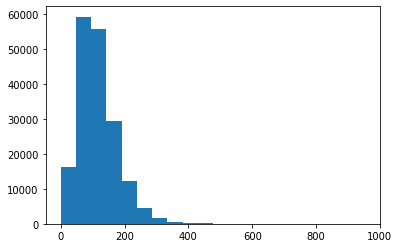

In [53]:
# Check distribution
plt.hist(chars_lens, bins = 20);

In [54]:
# find percentile
output_seq_char_len = int(np.percentile(chars_lens, 95))
output_seq_char_len

226

In [55]:
# get all keyboard characters( this is done so we can find out length of vocabulary)
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [56]:
NUM_CHAR_TOKENS = len(alphabet) + 2 # for space and OOV token (out of vocabulary)

# Create the char_vectorizer
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length = 226,
                                    name = "char_vectorizer")

In [57]:
# adapt the vectorizer to train data
char_vectorizer.adapt(train_chars)

In [58]:
# check character voacab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters: {len(char_vocab)}")
print(f"5 most common character: {char_vocab[:5]}")
print(f"5 least common character: {char_vocab[-5:]}")

Number of different characters: 28
5 most common character: ['', '[UNK]', 'e', 'i', 't']
5 least common character: ['k', 'x', 'z', 'q', 'j']


In [59]:
# Test the character vectorizer
random_train_char = random.choice(train_chars)
print(f"Charified test: \n{random_train_char}\n")
print(f"length of random train chars : {len(random_train_char.split())}\n")
vectorized = char_vectorizer([random_train_char])
print(f"vectorized:\n {vectorized}\n")
print(f"Shape of vectorzed: {vectorized.shape}")

Charified test: 
a l t h o u g h   d i f f e r e n t   p h a r m a c o l o g i c   a g e n t s     s u g g e s t e d     t r e a t m e n t     p t s d   n o n e       c o m p l e t e l y   e f f e c t i v e     e l i m i n a t i n g   s y m p t o m s

length of random train chars : 100

vectorized:
 [[ 5 11  4 17  9 15 16 17 12  3 20 20  2  8  2  6  4 13 17  5  8 14  5 10
   9 11  9 16  3 10  5 16  2  6  4  7  7 15 16 16  2  7  4  2 12  4  8  2
   5  4 14  2  6  4 13  4  7 12  6  9  6  2 10  9 14 13 11  2  4  2 11 18
   2 20 20  2 10  4  3 19  2  2 11  3 14  3  6  5  4  3  6 16  7 18 14 13
   4  9 14  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0]]

### Create character embedding layer

In [60]:
# create the layer
char_embed = layers.Embedding(input_dim= len(char_vocab),
                              output_dim = 25, 
                              name = "char_embed")

In [61]:
# Testing the embed layer
print(f"Charified test: \n{random_train_char}\n")
char_embed_example = char_embed(char_vectorizer([random_train_char]))
print(f"embed:\n {char_embed_example}\n")
print(f"shape: {char_embed_example.shape}")

Charified test: 
a l t h o u g h   d i f f e r e n t   p h a r m a c o l o g i c   a g e n t s     s u g g e s t e d     t r e a t m e n t     p t s d   n o n e       c o m p l e t e l y   e f f e c t i v e     e l i m i n a t i n g   s y m p t o m s

embed:
 [[[ 0.00585639 -0.00911891 -0.01399859 ...  0.03446249 -0.00496687
   -0.02822123]
  [ 0.03174374 -0.03925544 -0.0343066  ... -0.01520029 -0.04646082
    0.01131419]
  [-0.01136095  0.03555636  0.03356571 ... -0.02581275 -0.04863147
   -0.03457486]
  ...
  [ 0.03080301  0.00923901  0.02607368 ...  0.04352367 -0.04689893
   -0.04758933]
  [ 0.03080301  0.00923901  0.02607368 ...  0.04352367 -0.04689893
   -0.04758933]
  [ 0.03080301  0.00923901  0.02607368 ...  0.04352367 -0.04689893
   -0.04758933]]]

shape: (1, 226, 25)


### Creating positional embeddings

In [62]:
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

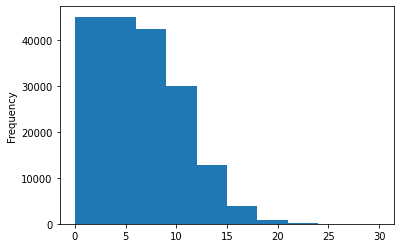

In [63]:
# plot the distribution
train_df['line_number'].plot.hist();

In [64]:
# One-hot-encoding for 'line_number' column
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth = 15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth = 15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth = 15) 

train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>, TensorShape([180040, 15]))

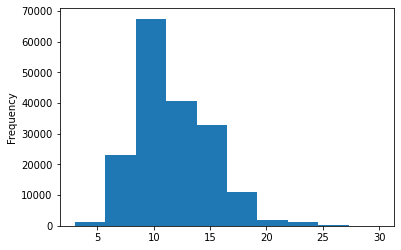

In [65]:
# Use one_hot for the total_lines as well
train_df.total_lines.plot.hist();

In [66]:
# check percentile
np.percentile(train_df.total_lines, 98)

20.0

In [67]:
# One hot encoding for the total_lines 
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth = 20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth = 20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth = 20) 

train_total_lines_one_hot[:5], train_total_lines_one_hot.shape

(<tf.Tensor: shape=(5, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.]], dtype=float32)>, TensorShape([180040, 20]))

## Preparing dataset for model using tf.data API

In [68]:
# Train dataset
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot))
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data,
                                                    train_char_token_pos_labels))
# Batch the train data and prefetch it 
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                                val_total_lines_one_hot,
                                                                val_sentences,
                                                                val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices((val_labels_one_hot))
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data,
                                                    val_char_token_pos_labels))

# Batch the validation dataset and prefetch it
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Test dataset
test_char_token_pos_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                                test_total_lines_one_hot,
                                                                test_sentences,
                                                                test_chars))
test_char_token_pos_labels = tf.data.Dataset.from_tensor_slices((test_labels_one_hot))
test_char_token_pos_dataset = tf.data.Dataset.zip((test_char_token_pos_data,
                                                    test_char_token_pos_labels))

# Batch the test dataset and prefetch it
test_char_token_pos_dataset = test_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_char_token_pos_dataset, val_char_token_pos_dataset, test_char_token_pos_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

## Creating the model

In [ ]:
# 1. Token Input
token_inputs = layers.Input(shape = (1, ), dtype = tf.string, name = 'token_input')
token_vectors = text_vectorizer(token_inputs)
token_embeddings = token_embed(token_vectors)
token_conv = layers.Conv1D(64, 10, padding = 'same', activation= 'relu')(token_embeddings)
pool = layers.GlobalMaxPooling1D(name='maxpool_1d')(token_conv)
token_outputs = layers.Dense(128, activation='relu')(pool)
token_model = tf.keras.Model(token_inputs, token_outputs)

# 2. Char Input
char_inputs = layers.Input(shape = (1, ), dtype= tf.string, name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_gru = layers.Bidirectional(layers.GRU(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_gru)

# 3. Create model for 'line_number' feature
line_number_inputs = layers.Input(shape = (15, ), dtype = tf.float32, name = 'line_number_inputs')
x = layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, x)

# 4. Create model for 'total_lines' feature
total_lines_inputs = layers.Input(shape = (20, ), dtype = tf.float32, name = 'total_lines_inputs') 
y = layers.Dense(32, activation='relu')(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs,y)

# 5. Combine steps 1 and 2 into hybrid embeddings
combined_embeddings = layers.Concatenate(name = "char_token_hybrid_embeddings")([token_model.output,
                                                                                 char_model.output])
z = layers.Dense(256, activation='relu')(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine 3, 4, 5 to form tribrid embedding
tribrid_embeddings = layers.Concatenate(name = "tribrid_embeddings")([line_number_model.output,
                                                                     total_lines_model.output,
                                                                     z])

# 7. Create GRU layer and feed forward layer
reshape = layers.Reshape((32,10))(tribrid_embeddings)
second_gru_layer = layers.Bidirectional(layers.GRU(100))(reshape)
feed_1 = layers.Dense(32, activation='relu')(second_gru_layer)
dropout_layer = layers.Dropout(0.5)(feed_1)

# 8. Create output layer
output_layer = layers.Dense(5, activation='softmax', name = 'output_layer')(dropout_layer)

# 9. Put together model
model_1 = tf.keras.Model(inputs = [line_number_model.input,
                                   total_lines_model.input,
                                   token_model.input,
                                   char_model.input],
                         outputs = output_layer,
                         name = 'ANN Model')

In [ ]:
model_1.summary()

Model: "word-char-pos-BiGRU"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 token_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 55)          0           ['token_input[0][0]']            
 ization)                                                                                         
                                                                                                  
 token_embedding_CUSTOM (Embedd  (None, 55, 128)     8299648     ['text_vectorization[0][0]']     
 ing)                                                                                             
                                                                                

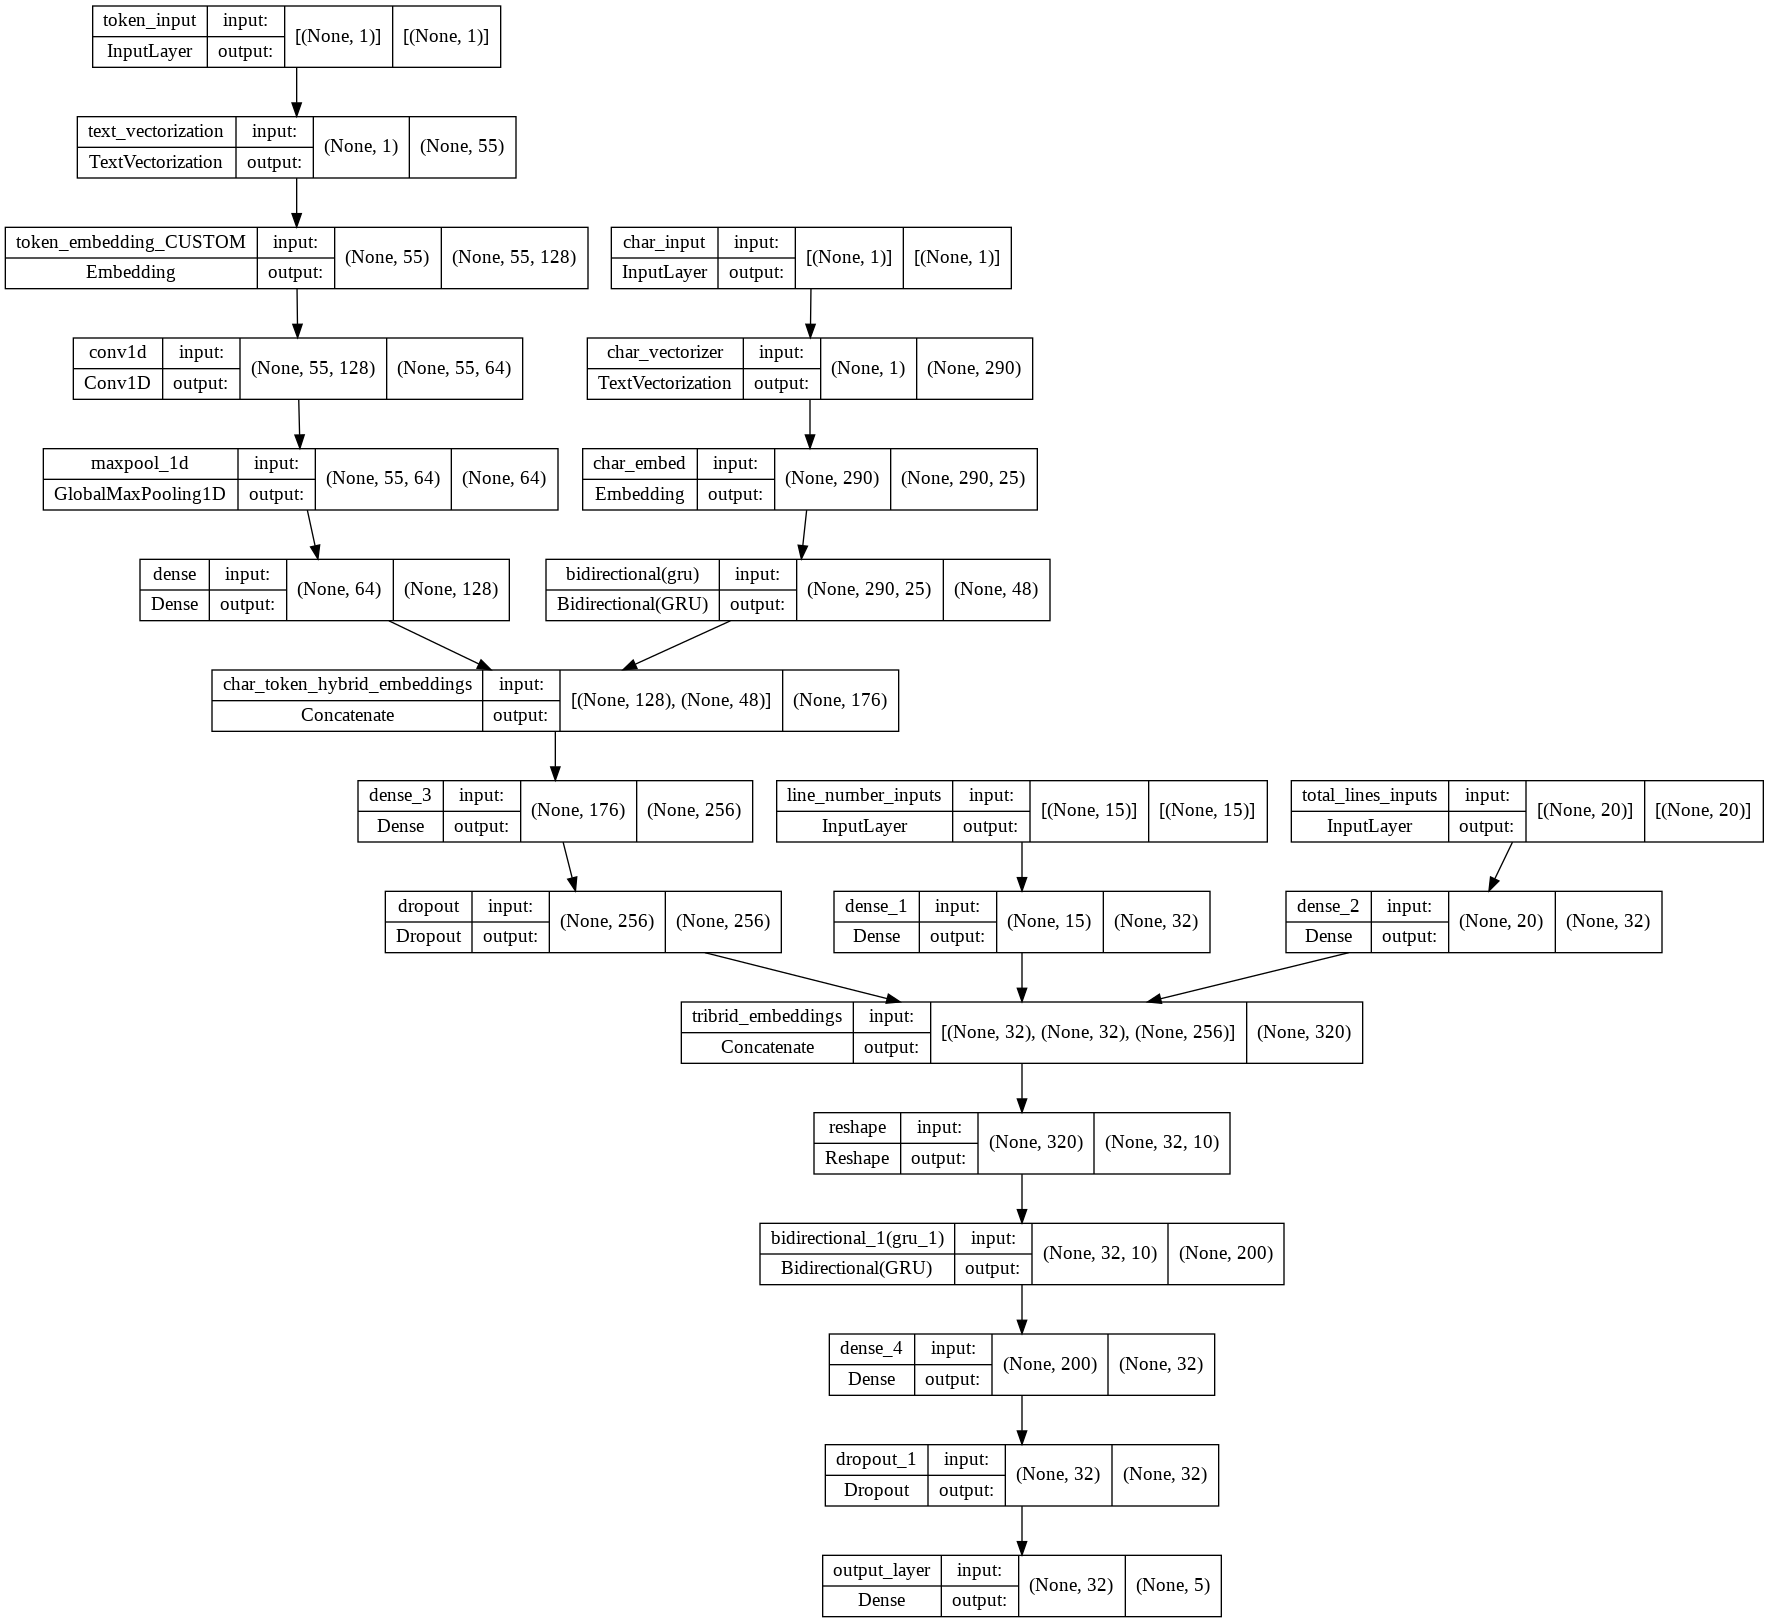

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model_1, show_shapes=True)

In [ ]:
# compile model
model_1.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.00001,
    patience=5,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False
)

In [ ]:
# fit the model
history = model_1.fit(train_char_token_pos_dataset,
                          steps_per_epoch = int(0.1*len(train_char_token_pos_dataset)),
                          epochs = 50,
                          callbacks=callback,
                          validation_data = val_char_token_pos_dataset,
                          validation_steps = int(0.1*len(val_char_token_pos_dataset)))

Epoch 1/50
562/562 [==============================] - 38s 33ms/step - loss: 1.1740 - accuracy: 0.6644 - val_loss: 0.9419 - val_accuracy: 0.7989
Epoch 2/50
562/562 [==============================] - 17s 31ms/step - loss: 1.0049 - accuracy: 0.7958 - val_loss: 0.9100 - val_accuracy: 0.8265
Epoch 3/50
562/562 [==============================] - 17s 31ms/step - loss: 0.9733 - accuracy: 0.8168 - val_loss: 0.8967 - val_accuracy: 0.8398
Epoch 4/50
562/562 [==============================] - 17s 31ms/step - loss: 0.9674 - accuracy: 0.8222 - val_loss: 0.8839 - val_accuracy: 0.8421
Epoch 5/50
562/562 [==============================] - 18s 32ms/step - loss: 0.9600 - accuracy: 0.8279 - val_loss: 0.8803 - val_accuracy: 0.8627
Epoch 6/50
562/562 [==============================] - 18s 32ms/step - loss: 0.9588 - accuracy: 0.8344 - val_loss: 0.8832 - val_accuracy: 0.8584
Epoch 7/50
562/562 [==============================] - 18s 31ms/step - loss: 0.9409 - accuracy: 0.8491 - val_loss: 0.8628 - val_accuracy:

562/562 [==============================] - 2s 3ms/step - loss: 0.9546 - accuracy: 0.8800 - val_loss: 0.8590 - val_accuracy: 0.8780


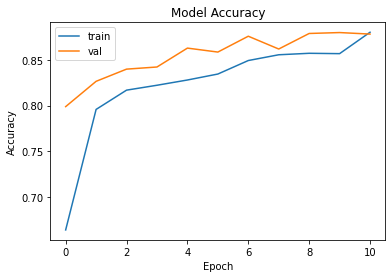

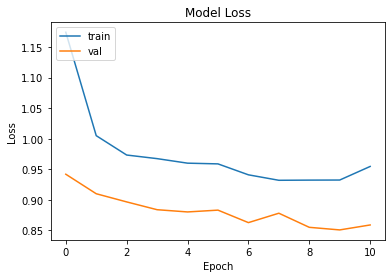

In [ ]:
# summarize history for accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# make prediction
model_1_pred_probs = model_1.predict(val_char_token_pos_dataset)
model_1_preds = tf.argmax(model_1_pred_probs, axis = 1)
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 0, 2, 2, 4, 4, 4, 4, 1])>

In [ ]:
# evaluate model1
model_1.evaluate(val_char_token_pos_dataset)

945/945 [==============================] - 14s 14ms/step - loss: 0.8506 - accuracy: 0.8809


[0.8505563735961914, 0.8809082508087158]

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

def calculate_results(y_true, y_pred):
    '''
    Calculates model accuracy, precision, recall, f1 score of a binary classification model
    
    Args:
        y_true: true labels in the form of a 1D array
        y_pred: predicted labels in the form of a 1D array
        
    Returns:
        A dictionary of metrics
    '''
    
    # Calculate the model accuracy
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    
    # Calculate the model precision, recall and f1 score
    model_precision = precision_score(y_true, y_pred, average='weighted')
    model_recall = recall_score(y_true, y_pred, average='weighted')
    model_f1 = f1_score(y_true, y_pred, average='weighted')
    
    model_results = {
        "accuracy": model_accuracy,
        "precision": model_precision,
        "recall": model_recall,
        "f1": model_f1
    }
    return model_results

In [ ]:
# Calculate results of token-char-positional hybrid model
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 88.06765523632993,
 'precision': 0.8858938862870062,
 'recall': 0.8806765523632993,
 'f1': 0.8759498090528492}

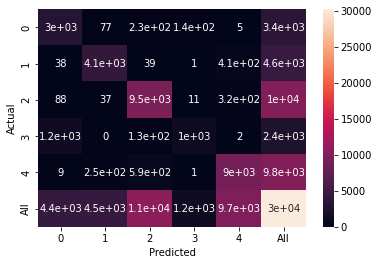

In [ ]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

data = {'y_Actual': val_labels_encoded,
        'y_Predicted':model_1_preds
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'], margins = True)

sn.heatmap(confusion_matrix, annot=True)
plt.show()

In [ ]:
import sklearn.metrics as skm
cm = skm.multilabel_confusion_matrix(val_labels_encoded, model_1_preds)
print(cm)
print( skm.classification_report(val_labels_encoded,model_1_preds))

[[[25408  1355]
  [  450  2999]]

 [[25263   367]
  [  492  4090]]

 [[19253   995]
  [  451  9513]]

 [[27684   152]
  [ 1356  1020]]

 [[19635   736]
  [  856  8985]]]
              precision    recall  f1-score   support

           0       0.69      0.87      0.77      3449
           1       0.92      0.89      0.90      4582
           2       0.91      0.95      0.93      9964
           3       0.87      0.43      0.57      2376
           4       0.92      0.91      0.92      9841

    accuracy                           0.88     30212
   macro avg       0.86      0.81      0.82     30212
weighted avg       0.89      0.88      0.88     30212



## Evaluate on Test Data

In [ ]:
# Create test dataset batch and prefetched
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check shapes
test_pos_char_token_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Make predictions on the test dataset
test_pred_probs = model_1.predict(test_pos_char_token_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 [==============================] - 13s 14ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 2, 2, 2, 4, 4, 4, 1, 1, 0])>

In [ ]:
# Evaluate loaded model test predictions
loaded_model_test_results = calculate_results(y_true=test_labels_encoded,
                                              y_pred=test_preds)
loaded_model_test_results

{'accuracy': 87.63563962170234,
 'precision': 0.8802763444486655,
 'recall': 0.8763563962170234,
 'f1': 0.8712592997199509}

## Make custom predictions

In [ ]:
# Few example of custom abstracts
trial = [{"abstract": "This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.", "source": "https://pubmed.ncbi.nlm.nih.gov/20232240/", "details": "RCT of a manualized social treatment for high-functioning autism spectrum disorders"}, {"abstract": "Postpartum depression (PPD) is the most prevalent mood disorder associated with childbirth. No single cause of PPD has been identified, however the increased risk of nutritional deficiencies incurred through the high nutritional requirements of pregnancy may play a role in the pathology of depressive symptoms. Three nutritional interventions have drawn particular interest as possible non-invasive and cost-effective prevention and/or treatment strategies for PPD; omega-3 (n-3) long chain polyunsaturated fatty acids (LCPUFA), vitamin D and overall diet. We searched for meta-analyses of randomised controlled trials (RCT's) of nutritional interventions during the perinatal period with PPD as an outcome, and checked for any trials published subsequently to the meta-analyses. Fish oil: Eleven RCT's of prenatal fish oil supplementation RCT's show null and positive effects on PPD symptoms. Vitamin D: no relevant RCT's were identified, however seven observational studies of maternal vitamin D levels with PPD outcomes showed inconsistent associations. Diet: Two Australian RCT's with dietary advice interventions in pregnancy had a positive and null result on PPD. With the exception of fish oil, few RCT's with nutritional interventions during pregnancy assess PPD. Further research is needed to determine whether nutritional intervention strategies during pregnancy can protect against symptoms of PPD. Given the prevalence of PPD and ease of administering PPD measures, we recommend future prenatal nutritional RCT's include PPD as an outcome.", "source": "https://pubmed.ncbi.nlm.nih.gov/28012571/", "details": "Formatting removed (can be used to compare model to actual example)"}, {"abstract": "Mental illness, including depression, anxiety and bipolar disorder, accounts for a significant proportion of global disability and poses a substantial social, economic and heath burden. Treatment is presently dominated by pharmacotherapy, such as antidepressants, and psychotherapy, such as cognitive behavioural therapy; however, such treatments avert less than half of the disease burden, suggesting that additional strategies are needed to prevent and treat mental disorders. There are now consistent mechanistic, observational and interventional data to suggest diet quality may be a modifiable risk factor for mental illness. This review provides an overview of the nutritional psychiatry field. It includes a discussion of the neurobiological mechanisms likely modulated by diet, the use of dietary and nutraceutical interventions in mental disorders, and recommendations for further research. Potential biological pathways related to mental disorders include inflammation, oxidative stress, the gut microbiome, epigenetic modifications and neuroplasticity. Consistent epidemiological evidence, particularly for depression, suggests an association between measures of diet quality and mental health, across multiple populations and age groups; these do not appear to be explained by other demographic, lifestyle factors or reverse causality. Our recently published intervention trial provides preliminary clinical evidence that dietary interventions in clinically diagnosed populations are feasible and can provide significant clinical benefit. Furthermore, nutraceuticals including n-3 fatty acids, folate, S-adenosylmethionine, N-acetyl cysteine and probiotics, among others, are promising avenues for future research. Continued research is now required to investigate the efficacy of intervention studies in large cohorts and within clinically relevant populations, particularly in patients with schizophrenia, bipolar and anxiety disorders.", "source": "https://pubmed.ncbi.nlm.nih.gov/28942748/", "details": "Effect of nutrition on mental health"}, {"abstract": "Hepatitis C virus (HCV) and alcoholic liver disease (ALD), either alone or in combination, count for more than two thirds of all liver diseases in the Western world. There is no safe level of drinking in HCV-infected patients and the most effective goal for these patients is total abstinence. Baclofen, a GABA(B) receptor agonist, represents a promising pharmacotherapy for alcohol dependence (AD). Previously, we performed a randomized clinical trial (RCT), which demonstrated the safety and efficacy of baclofen in patients affected by AD and cirrhosis. The goal of this post-hoc analysis was to explore baclofen's effect in a subgroup of alcohol-dependent HCV-infected cirrhotic patients. Any patient with HCV infection was selected for this analysis. Among the 84 subjects randomized in the main trial, 24 alcohol-dependent cirrhotic patients had a HCV infection; 12 received baclofen 10mg t.i.d. and 12 received placebo for 12-weeks. With respect to the placebo group (3/12, 25.0%), a significantly higher number of patients who achieved and maintained total alcohol abstinence was found in the baclofen group (10/12, 83.3%; p=0.0123). Furthermore, in the baclofen group, compared to placebo, there was a significantly higher increase in albumin values from baseline (p=0.0132) and a trend toward a significant reduction in INR levels from baseline (p=0.0716). In conclusion, baclofen was safe and significantly more effective than placebo in promoting alcohol abstinence, and improving some Liver Function Tests (LFTs) (i.e. albumin, INR) in alcohol-dependent HCV-infected cirrhotic patients. Baclofen may represent a clinically relevant alcohol pharmacotherapy for these patients.", "source": "https://pubmed.ncbi.nlm.nih.gov/22244707/", "details": "Baclofen promotes alcohol abstinence in alcohol dependent cirrhotic patients with hepatitis C virus (HCV) infection"}]
trial

[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

In [ ]:
# Extracting text from them
abstract_1 = trial[0]['abstract']
abstract_2 = trial[1]['abstract']
abstract_3 = trial[2]['abstract']
abstract_4 = trial[3]['abstract']
abstract_1

'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.'

In [ ]:
# function to prepare custom text
def prepare_text(abstract):
  custom_sentences = abstract.split(". ")
  char_sentences = [split_text(text) for text in custom_sentences]
  list_abstract = []
  for sentence_number, sentence in enumerate(custom_sentences):
    final_list = {}
    final_list['text'] = sentence.lower()
    final_list['line_number'] = sentence_number
    final_list['total_lines'] = len(custom_sentences) - 1
    list_abstract.append(final_list)

  return pd.DataFrame(list_abstract), char_sentences, custom_sentences

In [ ]:
# main function for making custom prediction
def predict_data(abstract, model):
  custom_df, custom_chars, custom_text = prepare_text(abstract)
  custom_line_number_one_hot = tf.one_hot(custom_df['line_number'].to_numpy(), depth = 15)
  custom_total_lines_one_hot = tf.one_hot(custom_df['total_lines'].to_numpy(), depth = 20)
  custom_dataset_first = tf.data.Dataset.from_tensor_slices((custom_line_number_one_hot,
                                                       custom_total_lines_one_hot,
                                                       custom_text,
                                                       custom_chars))

  custom_dataset_blank = tf.data.Dataset.from_tensor_slices((tf.squeeze(np.zeros(shape = (1, len(custom_text)+1)))))
  custom_dataset = tf.data.Dataset.zip((custom_dataset_first, custom_dataset_blank))
  custom_dataset = custom_dataset.batch(1)
  pred_probs = model_1.predict(custom_dataset)
  preds = tf.argmax(pred_probs, axis = 1)
  pred_class = [class_names[value] for value in preds]

  final_skim = []

  for i in range(len(custom_text)):
    final_dict = {}
    final_dict['Heading'] = pred_class[i]
    final_dict['Sentence in abstract'] = custom_text[i]
    final_skim.append(final_dict)
    print(f"{i+1}. {pred_class[i]} :- {custom_text[i]}\n----\n")


In [ ]:
predict_data(abstract_1, model_1)

1. OBJECTIVE :- This RCT examined the efficacy of a manualized social intervention for children with HFASDs
---

2. METHODS :- Participants were randomly assigned to treatment or wait-list conditions
---

3. METHODS :- Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language
---

4. METHODS :- A response-cost program was applied to reduce problem behaviors and foster skills acquisition
---

5. RESULTS :- Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures)
---

6. METHODS :- Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents
---

7. RESULTS :- High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity
---

8. RESULTS :- Standardized effect size estimates were primarily in the medium and large ran